## Random forest

랜덤 포레스트 (random forest)는 bagged tree를 트리 간의 decorrelation을 통해 향상시킨 개념으로 bagging 앙상블 기법 중 하나이다.

일반적인 bagging에서 bootstrap을 통해 만들어진 훈련 데이터 셋들은 서로 공유하는 데이터가 많아 이를 통해 만들어진 tree들은 높은 상관관계를 지니고 이에 따라 높은 variance를 유발한다.

랜덤 포레스트에서는 트리를 생성할 때, $p$개의 predictor중 임의로 선택된 $m$개의 predictor들을 후보로 하여 트리 분할을 진행한다.

- 일반적으로 $m \approx \sqrt{p}$로 한다.

- 즉, 랜덤 포레스트 방법은 트리 분할이 일어날 때 의도적으로 일부 predictor를 제외한다.

제외된 predictor들에는 strong predictor들도 있을 수 있는데 이들이 제외됨으로써 트리간의 decorrelation이 발생한다.

이러한 제외 과정이 없는 bagging에서는 사실 트리들이 모두 비슷비슷하게 생겼을 가능성이 높다.

아래 그림은 bagging과 random forest 방법에서의 에러를 계산한 예제로, random forest의 좋은 성능을 보여준다.

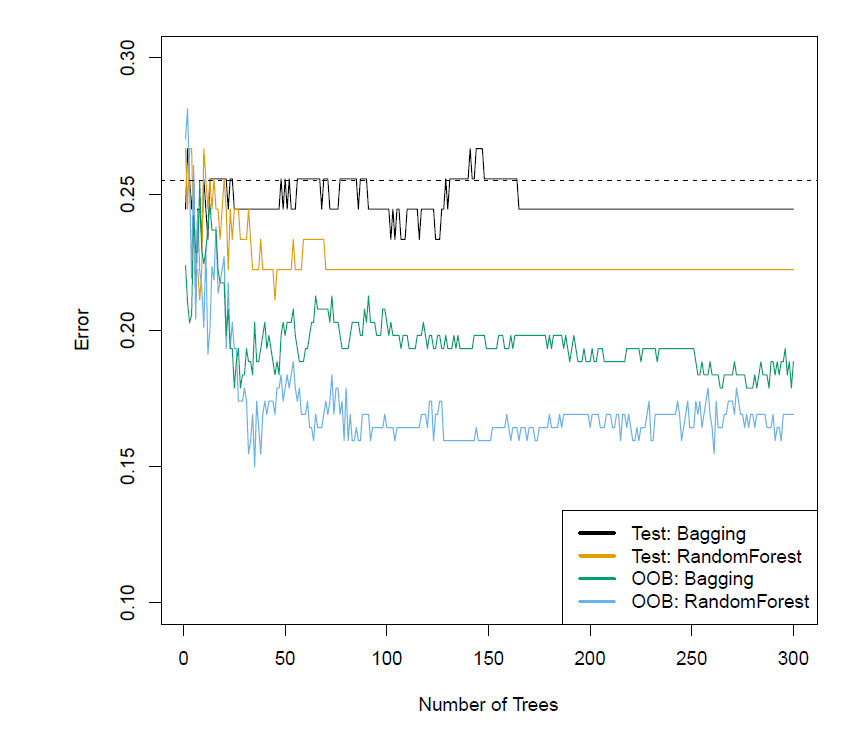

#### 예제 : make_moons

초승달 모양 클러스터 두 개 형상의 데이터를 생성하는 [```make_moons```](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)를 활용한 예제

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30)
X_train, X_test, y_train, y_test = train_test_split(X, y)

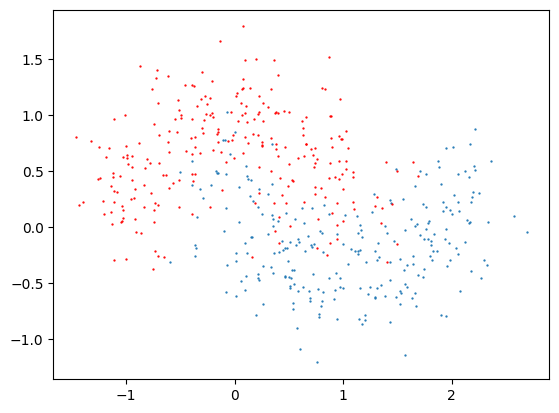

In [2]:
import matplotlib.pyplot as plt
plt.scatter(X[y==1, 0], X[y==1, 1], s = 0.4)
plt.scatter(X[y==0, 0], X[y==0, 1], s = 0.4, color="red")

plt.show()

먼저 validation set 방법을 이용하여 tree와 bagging의 accuracy를 비교해 본다.

[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)는 실제값과 모형을 통한 예측값을 비교하여 예측이 얼마나 정확한지를 평가한다.

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

단독의 `DecisionTreeClassifier`를 사용한 예제를 먼저 살펴보자.

나중에 살펴볼 bagging보다 더 적은 accuracy score를 보인다.

In [4]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.84


아래 방법과 동일한 결과

In [5]:
tree_clf.score(X_test, y_test)

0.84

그 다음 적은 수(`n_estimators`)의 decision tree를 사용한 bagging이다.

In [6]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), max_samples=100, n_estimators=5)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.84


Decision tree의 개수인 `n_estimators`를 늘려보자.

accuracy score가 향상되었다.

In [7]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), max_samples=100, n_estimators=300, oob_score=True)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.904


Decision boundary를 그려보자.

[`sklearn.inspection.DecisionBoundaryDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html)는 경계선을 그리기 위한 좋은 툴을 제공한다.

[`DecisionBoundaryDisplay.from_estimator`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html#sklearn.inspection.DecisionBoundaryDisplay.from_estimator)의 첫번째 파라미터인 `estimator`에 대상이 되는 훈련된 classifier를 넣어 준다.

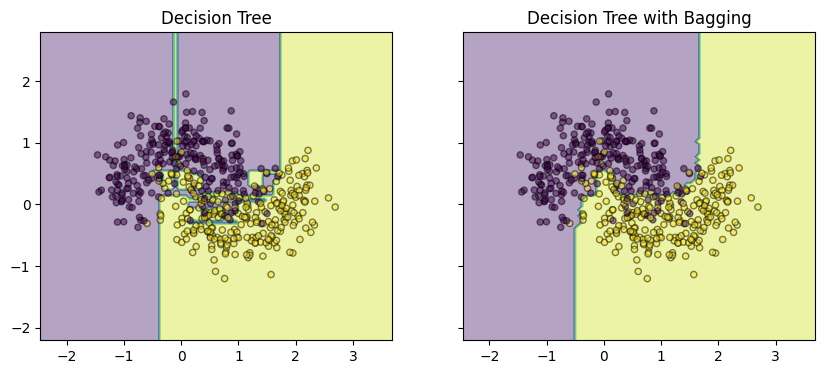

In [8]:
from sklearn.inspection import DecisionBoundaryDisplay

_, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(10,4))

for idx, clf, tt in zip([0, 1],
                        [tree_clf, bag_clf],
                        ["Decision Tree", "Decision Tree with Bagging"]):
    
    DecisionBoundaryDisplay.from_estimator(
        clf, X, alpha=0.4, ax=axarr[idx], response_method="predict"
    )
    axarr[idx].scatter(X[:, 0], X[:, 1], c = y, s = 20, edgecolor="k", alpha=0.5)
    axarr[idx].set_title(tt)

plt.show()

In [9]:
# 모든 데이터로 훈련하고 bagging 방법에 대한 oob score = 1 - clf.oob error를 계산
BaggingClassifier(
    DecisionTreeClassifier(), max_samples=100, n_estimators=300, bootstrap=True, oob_score=True)\
.fit(X, y).oob_score_

0.894

이제 랜덤 포레스트를 적용해 보자.

[`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

* ```n_estimators``` : default=100, 트리의 숫자
* ```max_features``` : ```max_features=sqrt(n_features)``` with default
* `max_depth` :  트리의 최대 깊이로, `None`이면 모든 잎이 pure하거나 모든 잎에 `min_samples_split` 샘플보다 적은 샘플이 포함될 때까지 노드가 확장됨
* `min_samples_split` : default = 2 
* `max_leaf_nodes` : 최대 leaf 노드의 수

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.904


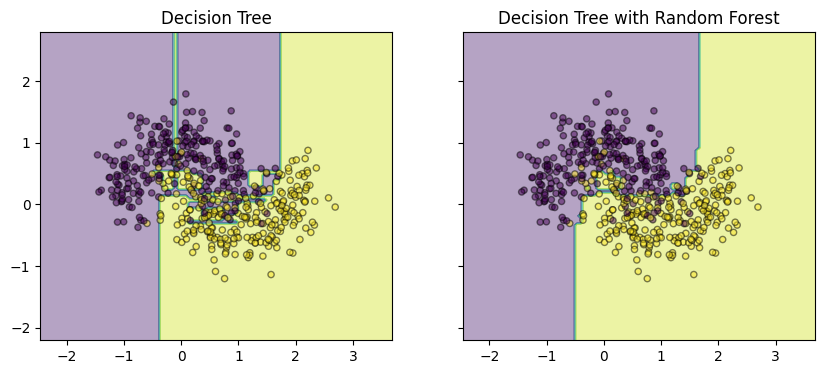

In [11]:
_, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(10,4))

for idx, clf, tt in zip([0, 1],
                        [tree_clf, rnd_clf],
                        ["Decision Tree", "Decision Tree with Random Forest"]):
    
    DecisionBoundaryDisplay.from_estimator(
        clf, X, alpha=0.4, ax=axarr[idx], response_method="predict"
    )
    axarr[idx].scatter(X[:, 0], X[:, 1], c = y, s = 20, edgecolor="k", alpha=0.5)
    axarr[idx].set_title(tt)

plt.show()

In [12]:
# 모든 데이터로 훈련하고 oob score를 계산
RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, oob_score=True).fit(X, y).oob_score_

0.888

#### 예제 : Bike Sharing data

[Bike Sharing Dataset Data Set](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) 데이터를 이용하여 `cnt`를 예측하는 예제

In [13]:
import pandas as pd
url = "https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter01/bike_rentals_cleaned.csv"
df = pd.read_csv(url)
df

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,1.0,1.0,12,0.0,4.0,1.0,2,0.254167,0.226642,0.652917,0.350133,2114
727,728,1.0,1.0,12,0.0,5.0,1.0,2,0.253333,0.255046,0.590000,0.155471,3095
728,729,1.0,1.0,12,0.0,6.0,0.0,2,0.253333,0.242400,0.752917,0.124383,1341
729,730,1.0,1.0,12,0.0,0.0,0.0,1,0.255833,0.231700,0.483333,0.350754,1796


In [14]:
X = df.loc[:,"season":"windspeed"]
y = df.loc[:,"cnt"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [17]:
y_pred = rf.predict(X_test)

In [18]:
# feature 중요도와 함께 출력
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
importances_df.sort_values(by='importance', ascending=False, inplace=True)
print(importances_df)

       feature  importance
7         temp    0.380158
1           yr    0.299135
8        atemp    0.089399
9          hum    0.067222
0       season    0.064056
10   windspeed    0.032995
2         mnth    0.031393
6   weathersit    0.016324
4      weekday    0.013168
5   workingday    0.003370
3      holiday    0.002780


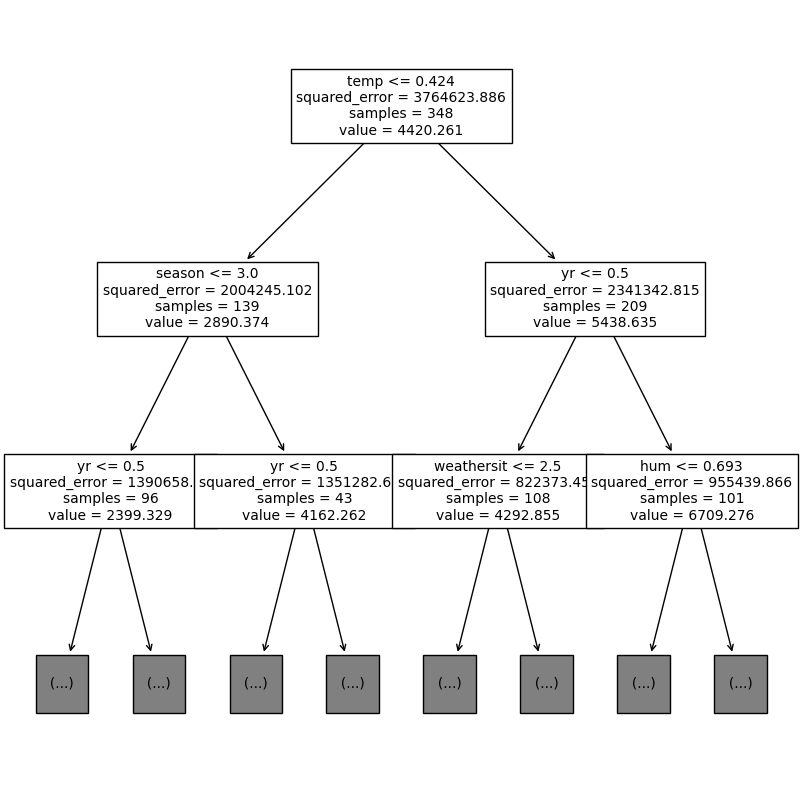

In [19]:
from sklearn.tree import plot_tree 
plt.figure(figsize=(10,10))
plot_tree(rf.estimators_[0], feature_names=X_train.columns, max_depth=2,  fontsize=10)
plt.show()

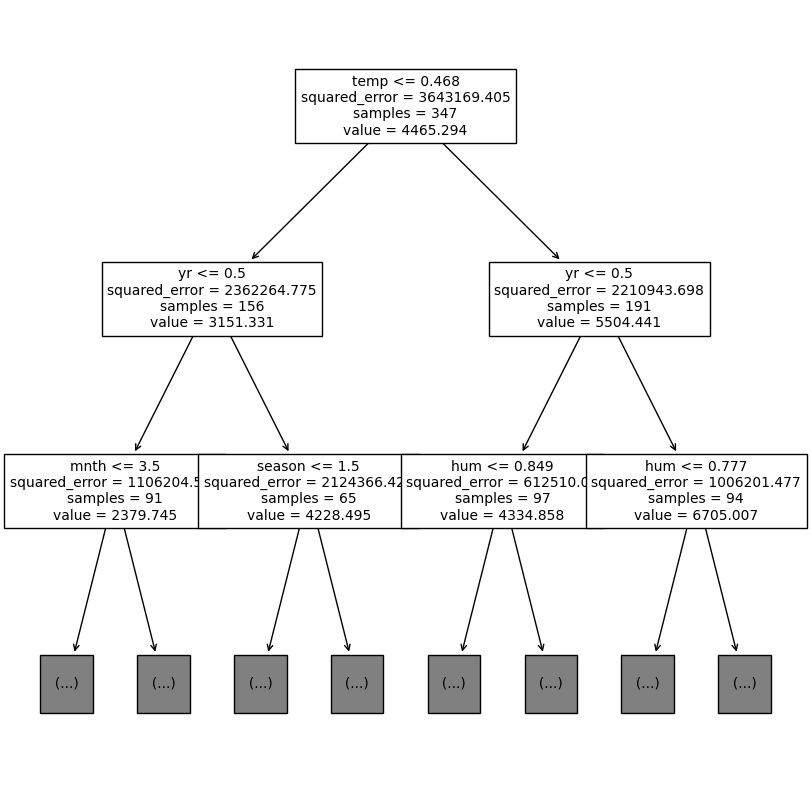

In [20]:
plt.figure(figsize=(10,10))
plot_tree(rf.estimators_[1], feature_names=X_train.columns, max_depth=2,  fontsize=10)
plt.show()

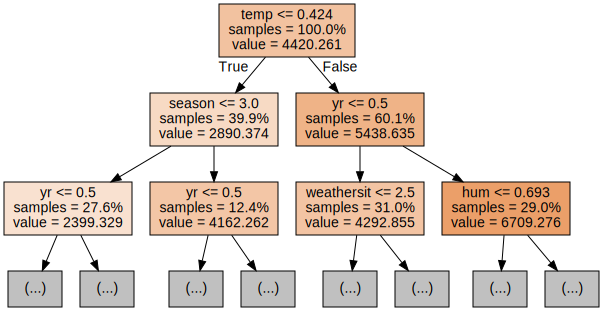

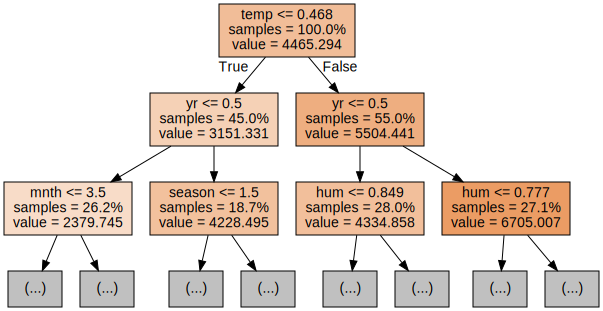

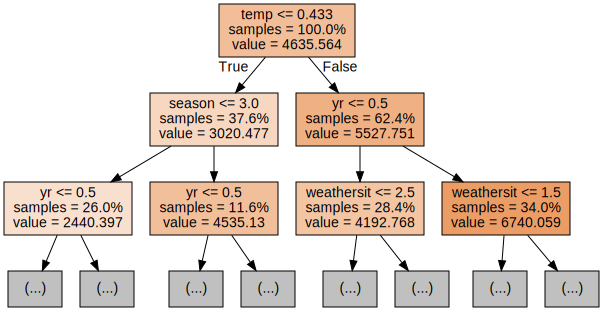

In [21]:
import graphviz
from sklearn.tree import export_graphviz

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

[`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate)를 이용하여 편리하게 k-fold cross-validation 에러를 계산할 수 있다.

여기서 `'neg_mean_squared_error'`는 MSE의 음수값을 나타냄

In [22]:
from sklearn.model_selection import cross_val_score 
import numpy as np

mse_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')
mse_mean = - mse_scores.mean()

print("RMSE:", np.sqrt(mse_mean))

RMSE: 953.0626047734565


단순 트리 모형과 비교

In [23]:
from sklearn.tree import DecisionTreeRegressor

tr = DecisionTreeRegressor()

tr_mse_scores = cross_val_score(tr, X, y, cv=5, scoring='neg_mean_squared_error')
tr_mse_mean = - tr_mse_scores.mean()

print("RMSE:", np.sqrt(tr_mse_mean))

RMSE: 1236.9800426052743


Bagging과 비교

In [24]:
from sklearn.ensemble import BaggingRegressor

bc = BaggingRegressor(estimator=DecisionTreeClassifier())

bc_mse_scores = cross_val_score(bc, X, y, cv=5, scoring='neg_mean_squared_error')
bc_mse_mean = - bc_mse_scores.mean()

print("RMSE:", np.sqrt(bc_mse_mean))

RMSE: 1732.0246953408384


#### 예제 : 연봉 데이터를 이용한 분류 문제

In [26]:
import pandas as pd
df_census = pd.read_csv("https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter02/census_cleaned.csv")

In [27]:
X = df_census.iloc[:,:-1]
y = df_census.iloc[:,-1]

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y)

In [34]:
rf = RandomForestClassifier(n_estimators=10, random_state=2, n_jobs=-1)

scores = cross_val_score(rf, X, y, cv=5)

print('정확도:', np.round(scores, 3))

print('정확도 평균: %0.3f' % (scores.mean()))

정확도: [0.851 0.844 0.851 0.852 0.851]
정확도 평균: 0.850


In [32]:
# 트리와의 비교
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
scores_tree = cross_val_score(clf, X, y, cv=5)
print('정확도:', np.round(scores_tree, 3))
print('정확도 평균: %0.3f' % (scores_tree.mean()))

정확도: [0.81  0.811 0.811 0.82  0.818]
정확도 평균: 0.814
